### Importa bibliotecas necessárias


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

### Importa o arquivo csv com a base de dados e transforma em DataFrame Pandas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
corona = pd.read_csv('/content/drive/MyDrive/Dados_UnB/Isolamento_MG.csv', encoding= 'utf-8',sep=';')
corona.head()

,Data,Distanciamento,Lojas/recreacao,Farmacias/Supermercado,Parques,Transporte,Trabalho,Residencia,Casos,Mortes
0,2/15/20,"31,6",7,5,11,10,8,0,0,0
1,2/16/20,"38,9",3,5,2,3,1,2,0,0
2,2/17/20,24,0,0,1,8,19,-1,0,0
3,2/18/20,"26,5",1,0,2,9,17,-1,0,0
4,2/19/20,"27,8",3,0,5,10,16,-1,0,0


In [ ]:
from datetime import datetime
corona.Data = pd.to_datetime(corona.Data, errors='coerce')
corona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    350 non-null    datetime64[ns]
 1   Distanciamento          350 non-null    object        
 2   Lojas/recreacao         350 non-null    int64         
 3   Farmacias/Supermercado  350 non-null    int64         
 4   Parques                 350 non-null    int64         
 5   Transporte              350 non-null    int64         
 6   Trabalho                350 non-null    int64         
 7   Residencia              350 non-null    int64         
 8   Casos                   350 non-null    int64         
 9   Mortes                  350 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 27.5+ KB


In [ ]:
corona['Distanciamento']= corona['Distanciamento'].apply(lambda x: float(x.replace(',', '.')))

In [ ]:
corona.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    350 non-null    datetime64[ns]
 1   Distanciamento          350 non-null    float64       
 2   Lojas/recreacao         350 non-null    int64         
 3   Farmacias/Supermercado  350 non-null    int64         
 4   Parques                 350 non-null    int64         
 5   Transporte              350 non-null    int64         
 6   Trabalho                350 non-null    int64         
 7   Residencia              350 non-null    int64         
 8   Casos                   350 non-null    int64         
 9   Mortes                  350 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 27.5 KB


### Visualização da Série Temporal

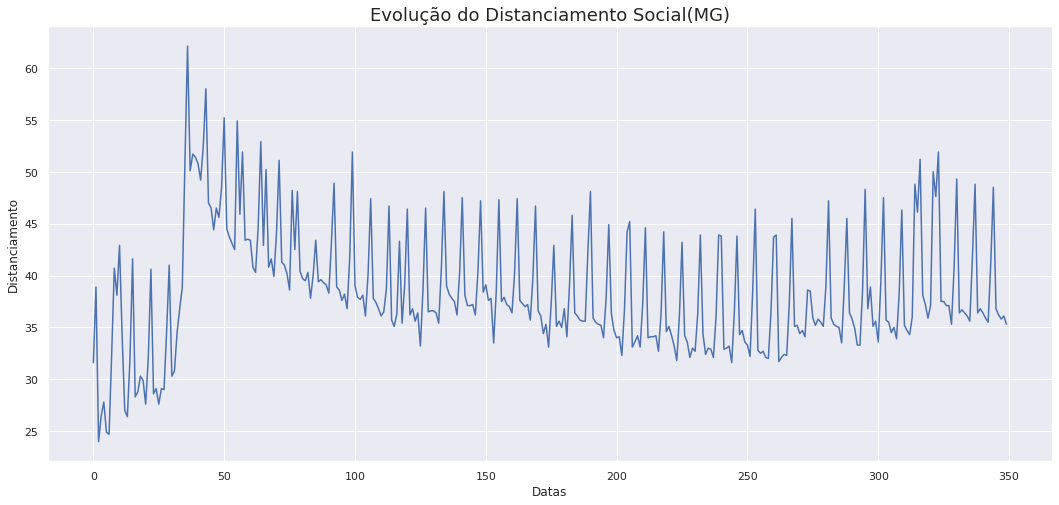

In [ ]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(18, 8)})
plt.plot(corona.Distanciamento)
plt.title( 'Evolução do Distanciamento Social(MG)', fontsize= 18)
plt.ylabel('Distanciamento')
plt.xlabel('Datas')

plt.show()


### Diferenciação da Série Temporal (redução de tendências e sazonalidade)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


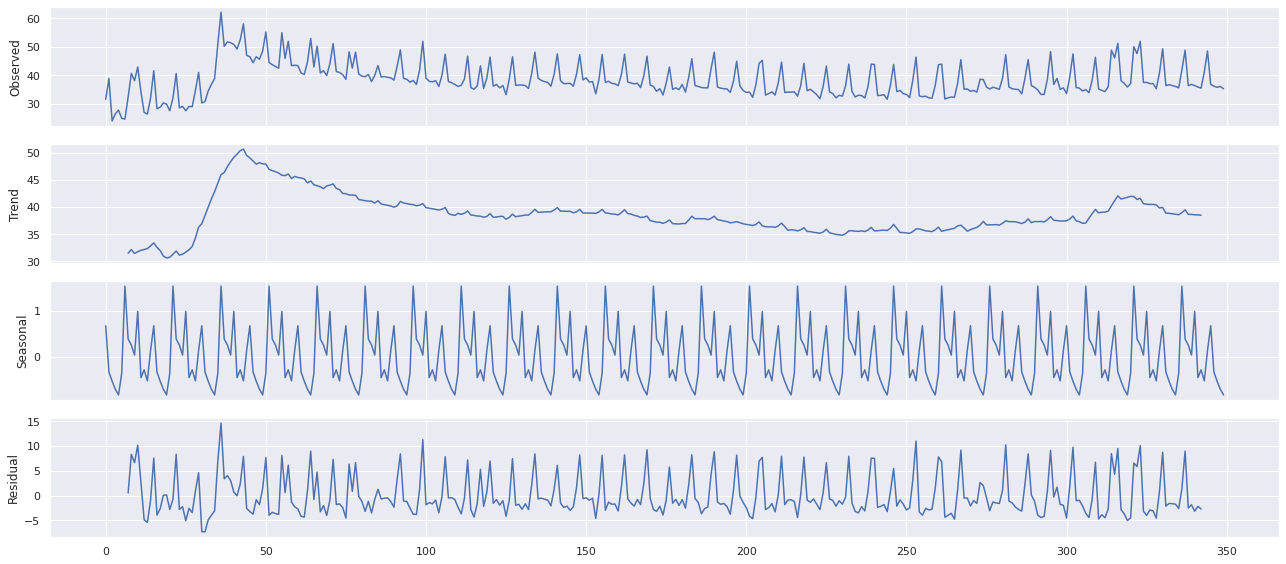

In [ ]:
import statsmodels.api as sm
decompfreq =15
res= sm.tsa.seasonal_decompose(corona.Distanciamento.interpolate(), freq= decompfreq, model= 'additive')
resplot=res.plot()



In [ ]:

# Usando uma função
def difference(dataset, interval =1):
  diff= list()
  for i in range(interval, len(dataset)):
    value= dataset[i] - dataset[i- interval]
    diff.append(value)
    return Series(diff)



In [ ]:
# Usando um recurso automático do pandas
corona.Distanciamento.diff()

0       NaN
1       7.3
2     -14.9
3       2.5
4       1.3
       ... 
345   -11.7
346    -0.6
347    -0.4
348     0.3
349    -0.8
Name: Distanciamento, Length: 350, dtype: float64

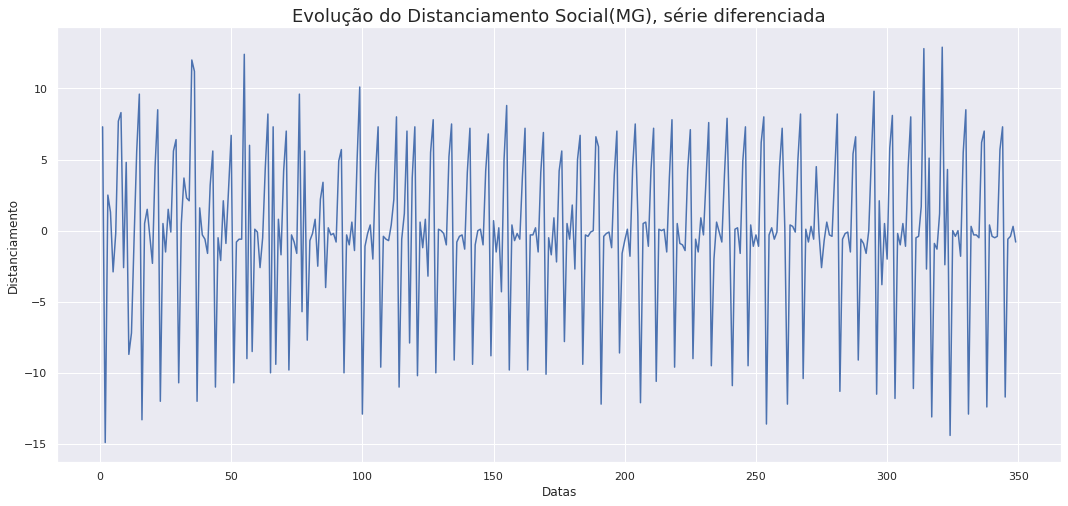

In [ ]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(18, 8)})
plt.plot(corona.Distanciamento.diff())
plt.title( 'Evolução do Distanciamento Social(MG), série diferenciada', fontsize= 18)
plt.ylabel('Distanciamento')
plt.xlabel('Datas')

plt.show()

### Ajustes necessários para uso da GPU, quando disponível

In [ ]:
# Normalização dos dados necessária para os modelos RNN/LSTM

training_set = corona.Distanciamento / corona.Distanciamento.max()


In [ ]:
 # Antes de mais nada é preciso fazer Runtime -> Change Runtime Type ->GPU
# Depois verificar o ambiente CUDA GPU
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.cuda.is_available())

1
0
Tesla T4
True


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# Sem GPU (caso não esteja disponível)
# dados devem ser transformados em tensores
dados  = torch.tensor(training_set)
print(dados.is_cuda)


False


In [ ]:
# Com GPU 
# dados devem ser transformados em tensores e carregados na GPU 

dados = torch.tensor(training_set)
dados = dados.to(device)
print(dados.is_cuda)

True


In [ ]:
print(dados.type())
print(dados.shape)
dados = dados.type(torch.float) 
print(dados.type())
print(dados.shape)

torch.cuda.DoubleTensor
torch.Size([350])
torch.cuda.FloatTensor
torch.Size([350])


### Função Janela

In [ ]:
# Define função janela
def Window(data, lenght_windows):
  lenght_data = data.shape[0]
  data_x = torch.zeros(lenght_data - lenght_windows-1, lenght_windows)
  data_y =  torch.zeros(lenght_data - lenght_windows-1)
   
  for i in range(lenght_windows):
    data_x[:,i] = data[i:lenght_data - lenght_windows -1 + i] 
  
  # Uma dimensão adicional é requerida
  data_y = data[lenght_windows:].unsqueeze(-1)
  return data_x.unsqueeze(-1), data_y 


### Modelo 1: LSTM com 1,2, 3 e 4 camadas

#### Classe LSTM

In [ ]:
# O modelo LSTM é uma classe Python sendo necessária somente a definição do método forward.
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential (
            nn.Dropout(0.1), nn.Linear(hidden_size, 1), #nn.ReLU()
            )
      

    def forward(self, x):
        out, (h_out, cn) = self.lstm(x)
     
        h_out = h_out[-1]                         # saída da última camada para a camada fc (full connected)
        h_out = h_out.view(-1,self.hidden_size)
        out_final = self.fc(h_out)

        return out_final

#### Delimitação dos Dados de Treinamento e Teste

In [ ]:
# separa dados de treinamento e teste
train_size = int(len(dados) * 0.8)
test_size = len(dados) - train_size

seq_length = 6
x, y = Window(dados, seq_length)

x, y = x.to(device), y.to(device) # importante para o uso de GPU

trainX, trainY  = x[:train_size],y[:train_size]
testX, testY = x[train_size:],y[train_size:]

No handles with labels found to put in legend.


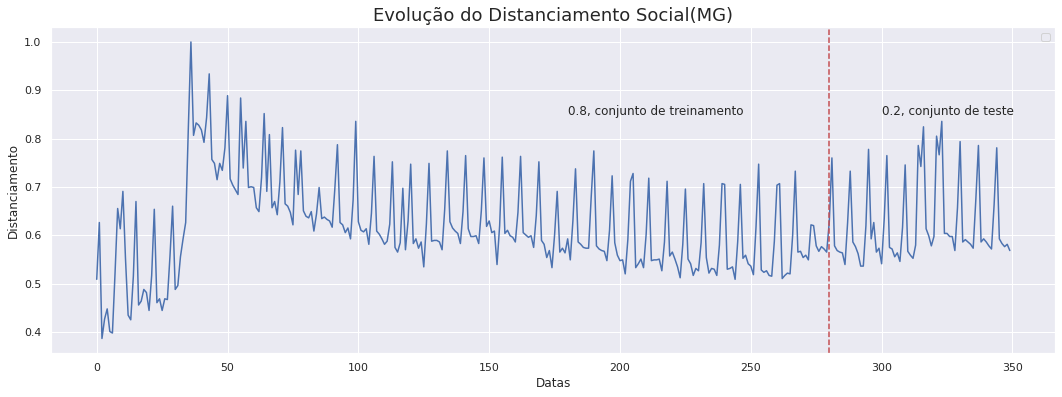

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(training_set)
ax.axvline(x=train_size, c='r', linestyle='--')
ax.set_title('Evolução do Distanciamento Social(MG)', fontsize=18)
ax.set_xlabel("Datas")
ax.set_ylabel("Distanciamento")

ax.text(train_size - 100, 0.85, '0.8, conjunto de treinamento', fontsize=12)
ax.text(train_size + 20, 0.85, '0.2, conjunto de teste', fontsize=12)
ax.legend()

plt.show()

#### Treinamento do Modelo 1

In [ ]:
# Função de treinamento

def train(model, optimizer, loss_f, num_epochs, data_train_x, data_train_y):
  running_loss= 0.0
  train_losses =[] 
  test_losses =[] 
  for epoch in range(num_epochs):
    
    outputs = model(data_train_x)
    loss = loss_f(outputs, data_train_y)
    running_loss =+ loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(running_loss/train_size)
    test_losses.append(running_loss/test_size)
    if epoch %500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
  plt.figure(figsize=(20,5))
  plt.plot(train_losses, label= 'train')
  plt.plot(test_losses, Label= 'test')
  plt.title('Loss History', fontsize=14)
  plt.legend()

    
   


Epoch: 0, loss: 0.48037
Epoch: 500, loss: 0.00669
Epoch: 1000, loss: 0.00603
Epoch: 1500, loss: 0.00574


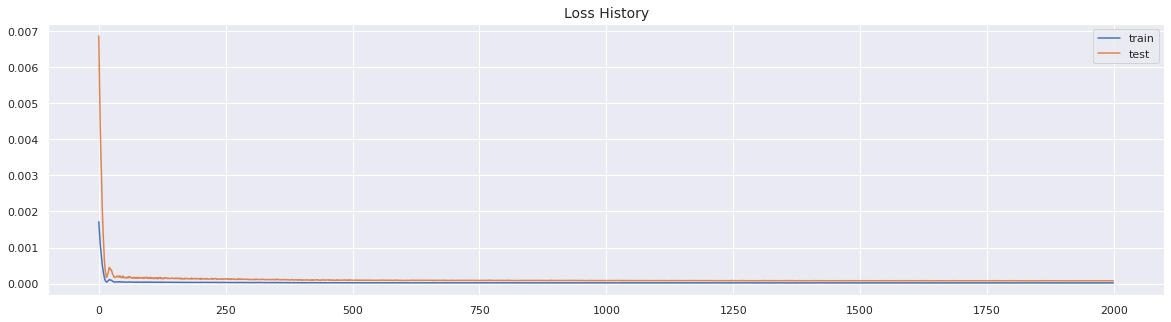

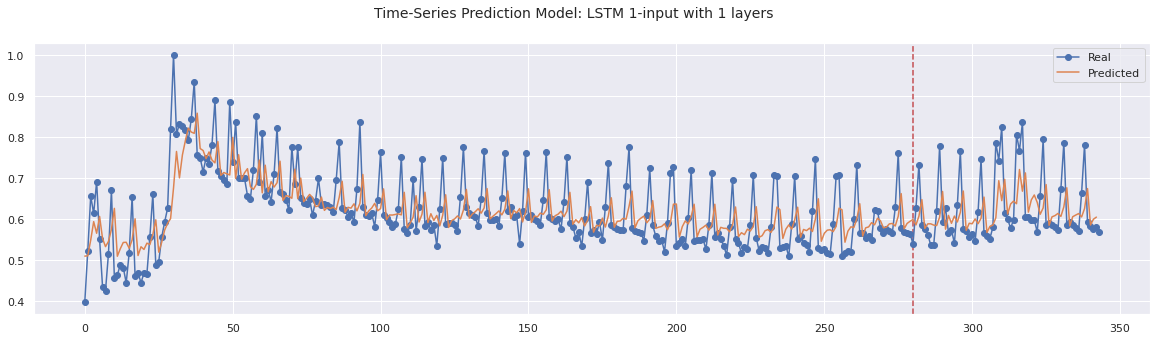

Epoch: 0, loss: 1.19144
Epoch: 500, loss: 0.01105
Epoch: 1000, loss: 0.00654
Epoch: 1500, loss: 0.00523


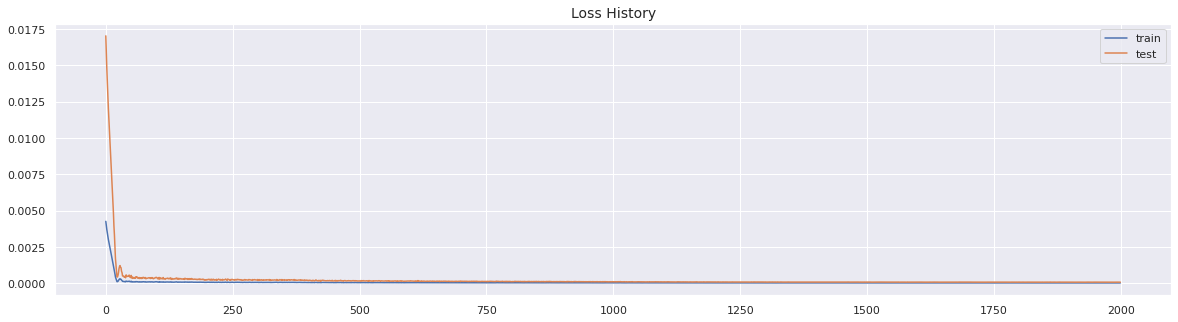

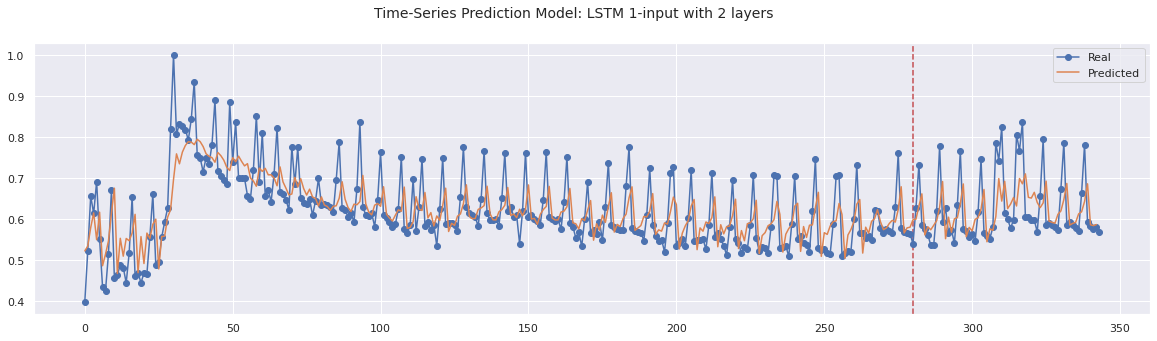

Epoch: 0, loss: 1.04347
Epoch: 500, loss: 0.01432
Epoch: 1000, loss: 0.00631
Epoch: 1500, loss: 0.00336


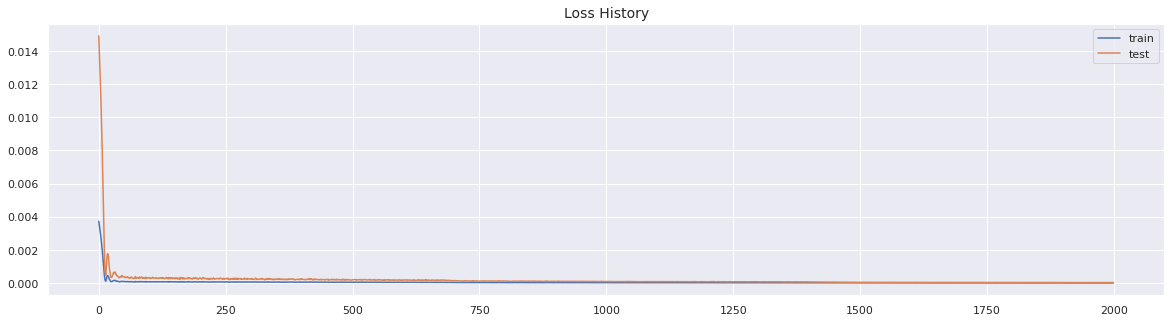

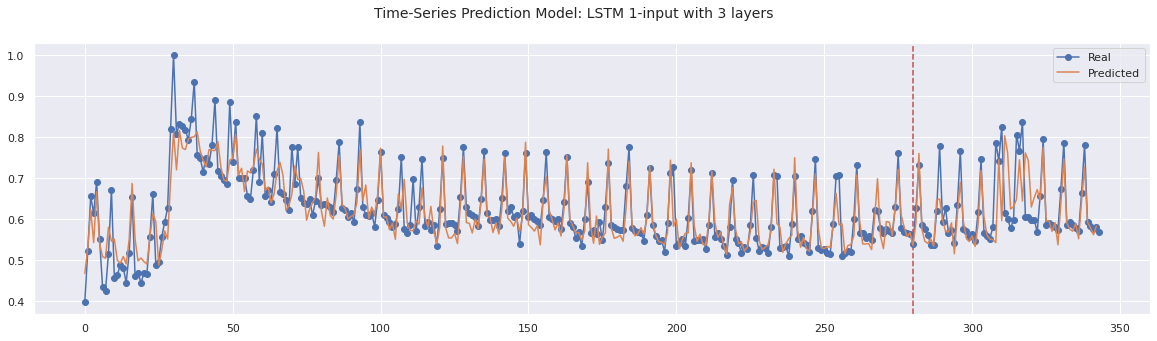

Epoch: 0, loss: 0.43036
Epoch: 500, loss: 0.01007
Epoch: 1000, loss: 0.00362
Epoch: 1500, loss: 0.00140


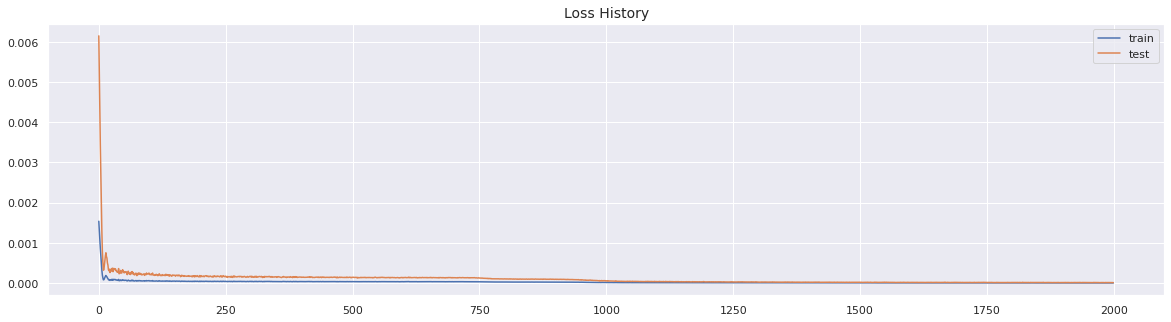

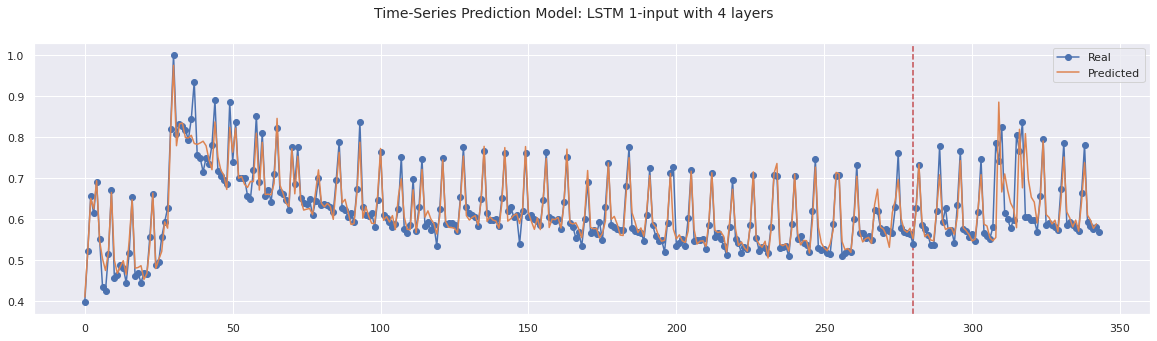

In [ ]:

num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size!!! uma única série de dados
hidden_size = 6

for num_layers in range(1,5):

  # num_layers = 1, 2, 3, 4

  model = LSTM(input_size, hidden_size, num_layers)
  model = model.to(device)

  loss_function = torch.nn.MSELoss() 

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

  train(model, optimizer, loss_function, num_epochs, trainX, trainY)

  model.eval()
  prediction = model(x.to(device))
  data_predict = prediction.to('cpu').data.numpy()
  dataY_plot = y.to('cpu').data.numpy()
  

  plt.figure(figsize=(20,5))
  plt.axvline(x=train_size, c='r', linestyle='--')
  plt.plot(dataY_plot, marker='o', label='Real')
  plt.plot(data_predict, Label='Predicted')
  plt.legend()
  plt.suptitle(f'Time-Series Prediction Model: LSTM 1-input with {num_layers} layers', fontsize=14)
  
  plt.savefig('plot_lstm1_' + str(num_layers) + '_layers.png')
  plt.show()




### Modelo 2: RNN com 1,2,3,e 4 camadas

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential (
            nn.Dropout (0.5), nn.Linear(hidden_size, 1), # nn.ReLU()
        )

    def forward(self, x):
        out, h_out = self.rnn(x)                  # dois parâmetros e não três como na lstm
     
        h_out = h_out[-1]                         # saída da última camada para a camada fc
        h_out = h_out.view(-1,self.hidden_size)  
        out_final = self.fc(h_out)

        return out_final

#### Treinamento do Modelo 2

Epoch: 0, loss: 0.73330
Epoch: 500, loss: 0.00688
Epoch: 1000, loss: 0.00654
Epoch: 1500, loss: 0.00648


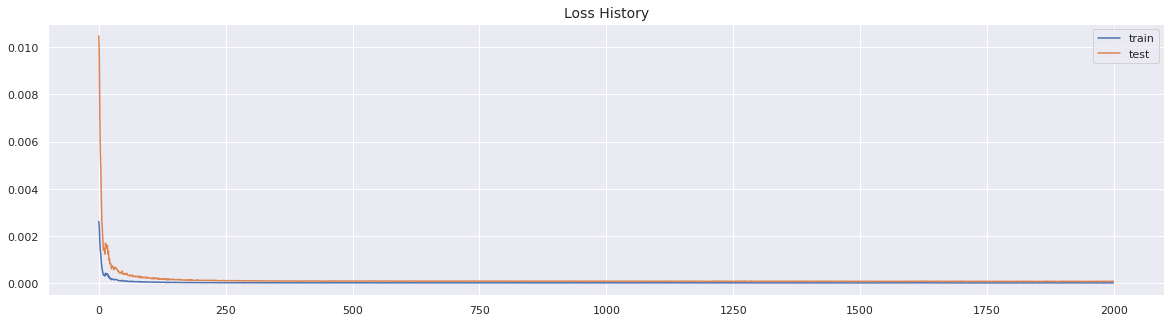

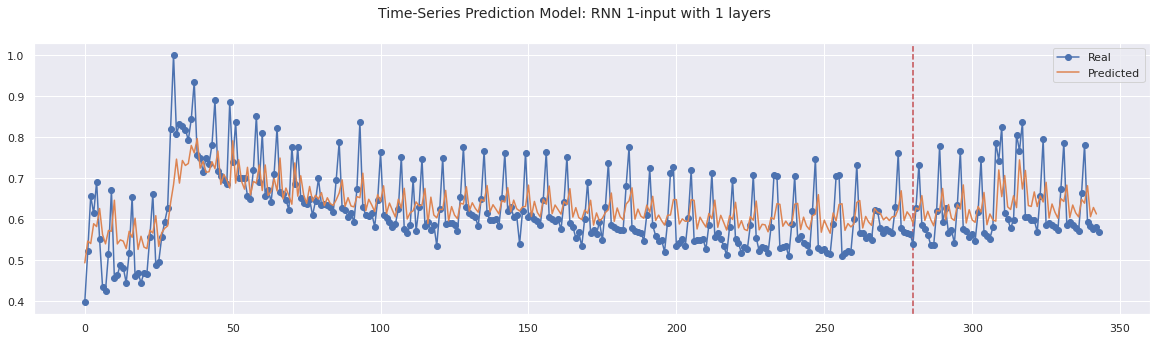

Epoch: 0, loss: 1.25040
Epoch: 500, loss: 0.00665
Epoch: 1000, loss: 0.00664
Epoch: 1500, loss: 0.00649


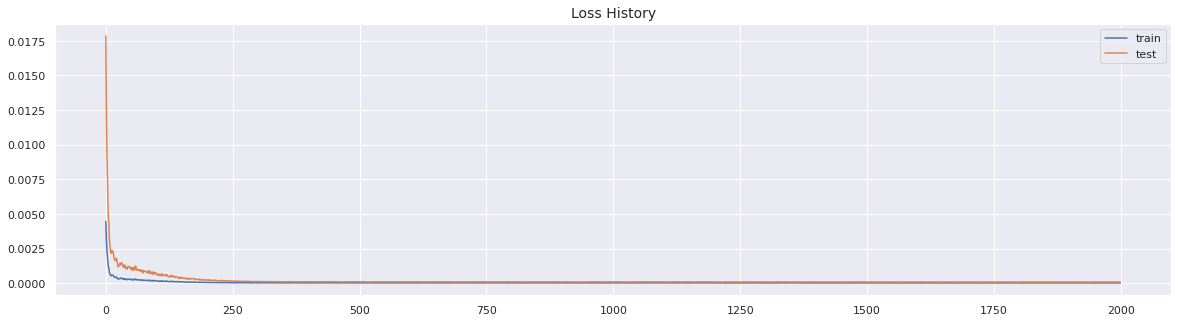

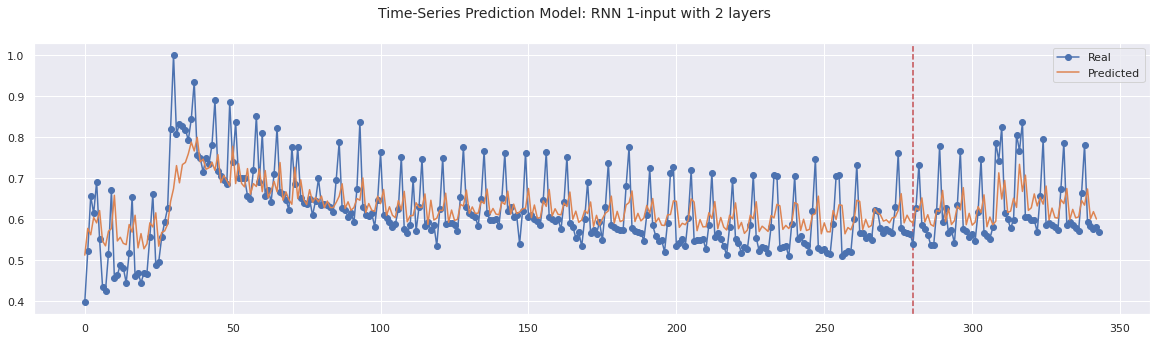

Epoch: 0, loss: 0.64501
Epoch: 500, loss: 0.00588
Epoch: 1000, loss: 0.00538
Epoch: 1500, loss: 0.00472


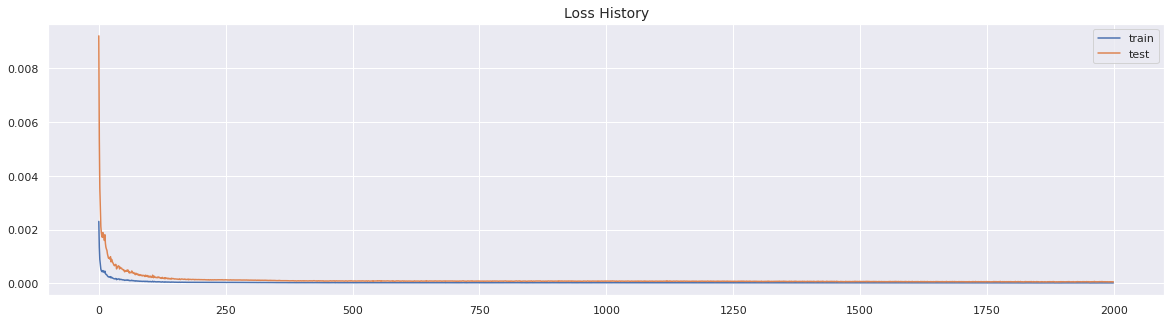

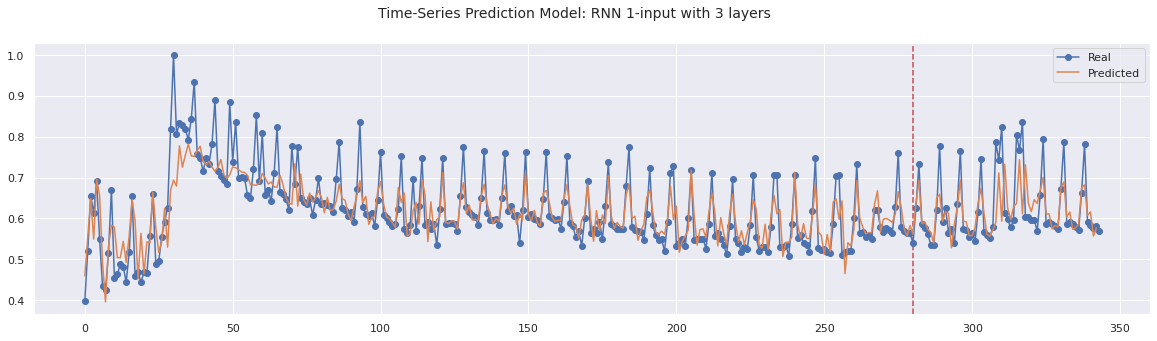

Epoch: 0, loss: 0.10832
Epoch: 500, loss: 0.00569
Epoch: 1000, loss: 0.00383
Epoch: 1500, loss: 0.00323


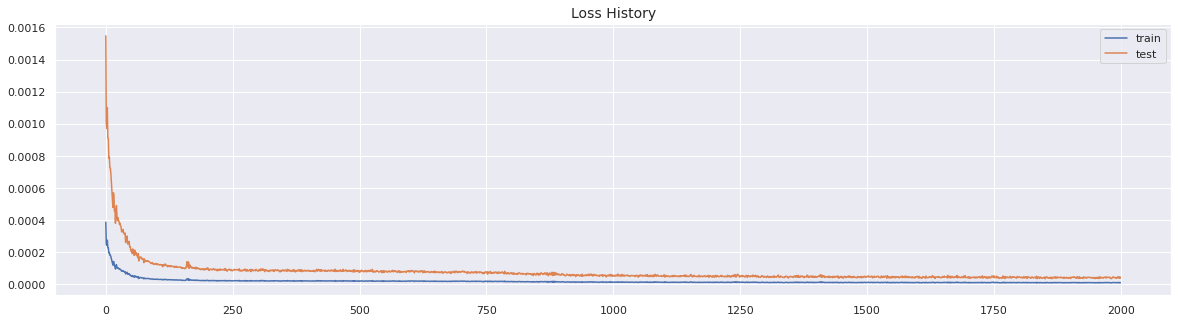

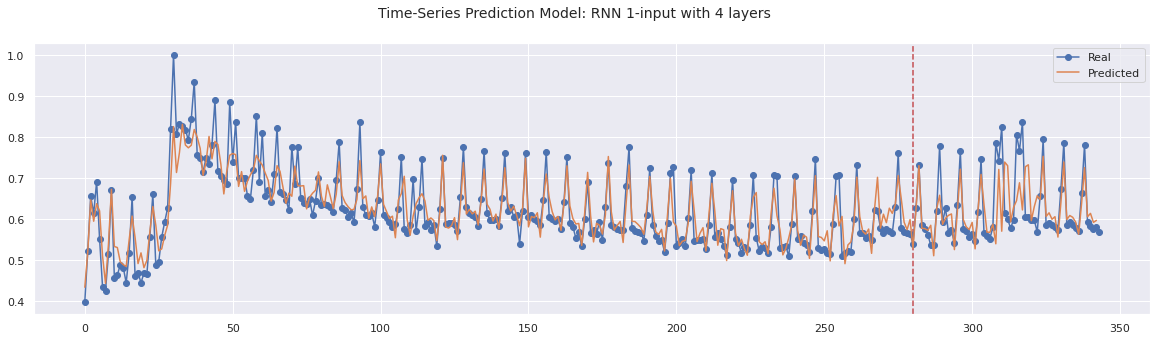

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size, uma única série de dados
hidden_size = 6

for num_layers in range(1,5):

  # num_layers = 1, 2, 3, 4

  model = RNN(input_size, hidden_size, num_layers)
  model = model.to(device)

  loss_function = torch.nn.MSELoss()    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, trainX, trainY)

  model.eval()
  prediction = model(x.to(device))
  data_predict = prediction.to('cpu').data.numpy()
  dataY_plot = y.to('cpu').data.numpy()

  plt.figure(figsize=(20,5))
  plt.axvline(x=train_size, c='r', linestyle='--')
  plt.plot(dataY_plot, marker='o', label='Real')
  plt.plot(data_predict, Label='Predicted')
  plt.legend()
  plt.suptitle(f'Time-Series Prediction Model: RNN 1-input with {num_layers} layers', fontsize=14)
  
  plt.savefig('plot_rnn1_' + str(num_layers) + '_layers.png')
  plt.show()

### Melhores Resultados dos Dois Modelos

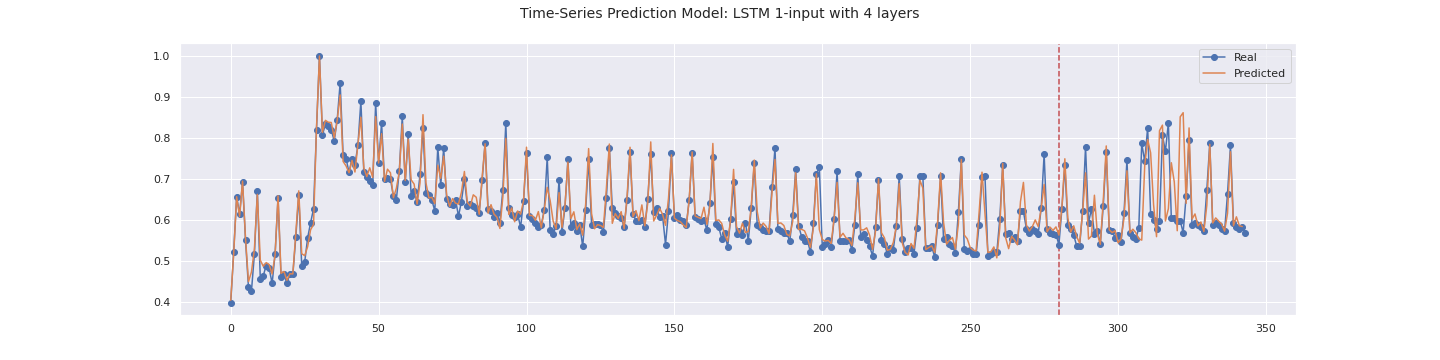

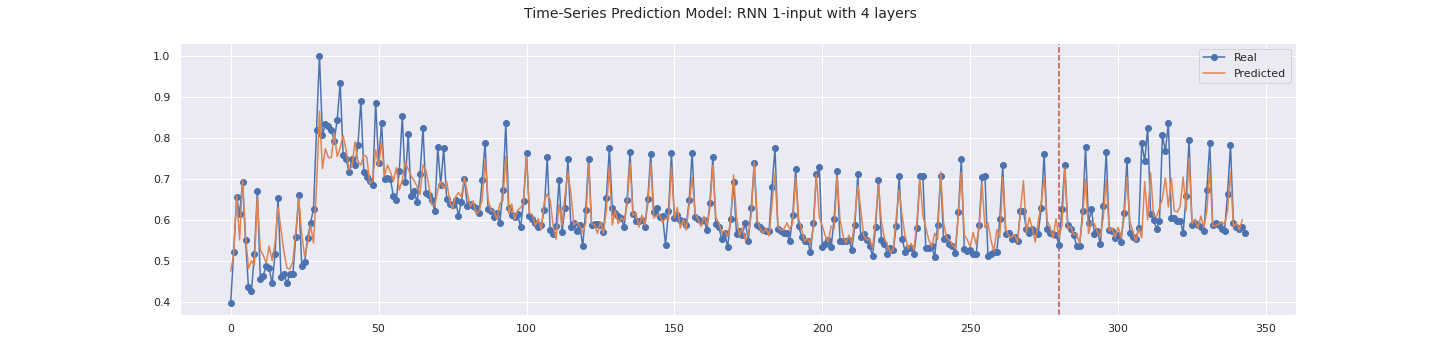

In [ ]:
from IPython.display import Image, display
display(Image('/content/plot_lstm1_4_layers.png'))
display(Image('/content/plot_rnn1_4_layers.png'))

### Análise de Overfitting

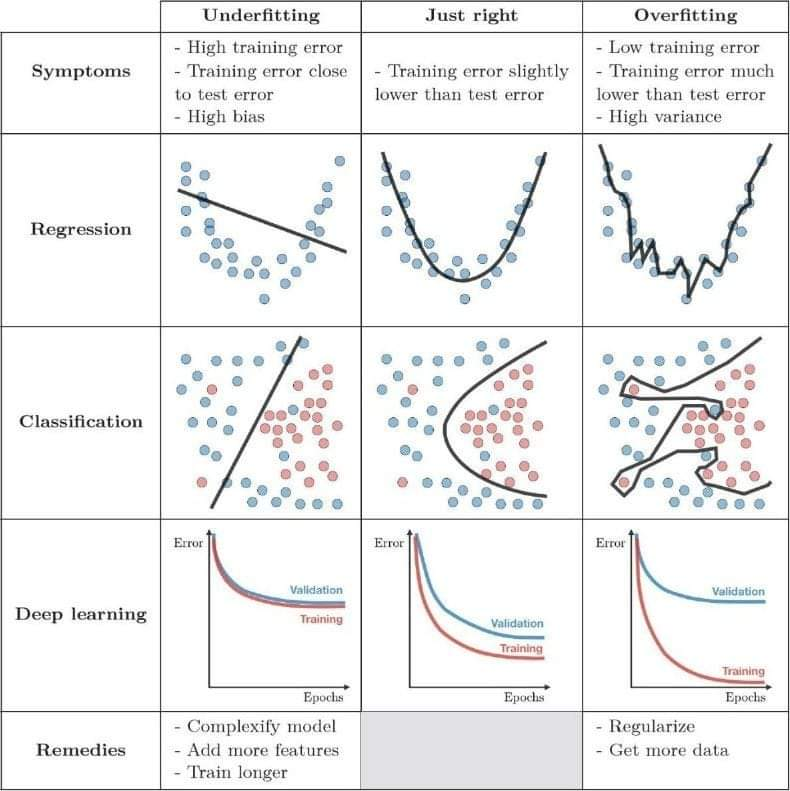

In [ ]:
from IPython.display import Image, display
display(Image ('/content/drive/MyDrive/Dados_UnB/FB_IMG_1613520166447.jpg'))


Modelo RNN necessitou de Dropout = 0.5 para reduzir erro e overfitting.